In [240]:
import pandas as pd
import numpy as np
import re
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1
from gensim.models import FastText
import ipdb
import spacy
import tqdm

In [3]:
# !pip install ipdb
# !pip install torchmetrics

In [6]:
# !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
# !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

In [7]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [8]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets['tone'] = 0

In [9]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [10]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [107]:
def preprocess(text): 
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.split()

In [117]:
tweets_data['prep_text'] = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))

In [118]:
tweets_data

,text,tone,prep_text
67849,RT @fuck_kakain: @dasha_1D_ Вроде. Потому что ...,1,rt USER USER вроде потому что я с этих слов на...
99432,"@suicidebananas :""( 25 билетов, хз сколько это...",0,USER 25 билетов хз сколько это страниц
45663,"@mishanicolaev да, ага, им эти поля футбольные...",1,USER да ага им эти поля футбольные нахуй не нужны
51253,нужно пересмотреть свои взгляды на жизнь (,0,нужно пересмотреть свои взгляды на жизнь
34830,Третий день НИХРЕНА не готовлюсь к сессии.Я го...,0,третий день нихрена не готовлюсь к сессии я го...
...,...,...,...
2099,@foxnastya97 с тобой ахуенно смотреть ужааасти...,1,USER с тобой ахуенно смотреть ужааастииикииии 3
102704,"Гуфака встретился с Сэмом ""Оказывается я так с...",1,гуфака встретился с сэмом оказывается я так ск...
30259,У меня экран на телефоне страшно поцарапался :...,0,у меня экран на телефоне страшно поцарапался х...
87256,сегодня будем целый день спать! ну очень лень ...,0,сегодня будем целый день спать ну очень лень к...


In [174]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.2)

In [175]:
train_sentences[train_sentences.tone == 1].shape[0] /train_sentences.shape[0]

0.504975

In [176]:
vocab = Counter()

for text in tweets_data['prep_text']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 110842


In [177]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 14917


In [178]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [179]:
id2word = {i:word for word, i in word2id.items()}

In [180]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [181]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [182]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [183]:
batch = next(iter(train_iterator))
batch[0].shape

torch.Size([1024, 20])

In [184]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [185]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 20])

In [186]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=140, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)       
        return logits

### Training model

In [187]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [188]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке


In [191]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### Обучим эмбеддинг слой на нашей модели

In [192]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7667672038078308
Train loss: 0.7342740893363953
Train loss: 0.7236179221760143
Train loss: 0.7172105079990322
Train loss: 0.7134825965842685

Evaluating on train...
Val loss: 0.7387108589921679, Val f1: 0.5606797933578491
Val loss: 0.7134110167108733, Val f1: 0.5360041856765747
Val loss: 0.7051611027934335, Val f1: 0.5306762456893921
Val loss: 0.701465746103707, Val f1: 0.5264858603477478
Val loss: 0.6990658302564878, Val f1: 0.524857223033905

Evaluating on test...
Val loss: 0.9217373927434286, Val f1: 0.6872689127922058
Val loss: 0.7891773070607867, Val f1: 0.5923547744750977
Val loss: 0.7535216429016807, Val f1: 0.5655909776687622
Val loss: 0.7363164226214091, Val f1: 0.5496065020561218
Val loss: 0.7265706626992476, Val f1: 0.5440840721130371

starting Epoch 1
Training...
Train loss: 0.7484379623617444
Train loss: 0.7213709703807173
Train loss: 0.7122779989784415
Train loss: 0.7077026801594233
Train loss: 0.7046956629366488

Evaluating on 

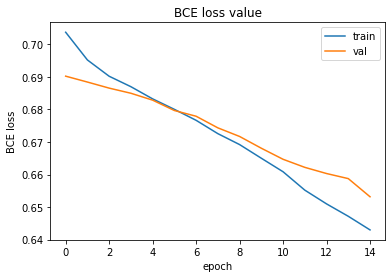

In [193]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

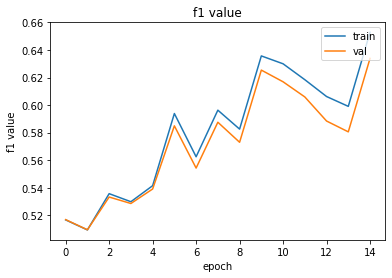

In [194]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [195]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [196]:
fp, fn, tp, tn = predict(model, val_iterator)

In [197]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.6345057034220533

результаты сомнительные...графики тоже не очень, попробуем улучшить модель.

In [198]:
fn[:5]

['как хотя вы такие что не',
 'ni вообще я залил всю клаву',
 'скучно наверно фильм смотреть хз',
 'же что без тебя серо и будь рядом',
 'вышел с к чтобы конфеты не забрали я всю химию ржу от этих конфет']

### Подгрузим обученные эмбеддинги Fasttext

In [199]:
texts = tweets_data.prep_text.tolist()

In [200]:
ft = FastText(texts, size=100, window=5, min_count=1)

In [201]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [202]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=140, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [203]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [204]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7868708883013044
Train loss: 0.7479735057929466
Train loss: 0.7325857173312794
Train loss: 0.7243273167286889
Train loss: 0.7190316085879868

Evaluating on train...
Val loss: 0.73715626341956, Val f1: 0.5672937631607056
Val loss: 0.7106868460260588, Val f1: 0.5518511533737183
Val loss: 0.7028832029212605, Val f1: 0.5427787899971008
Val loss: 0.6984985743538809, Val f1: 0.5420497059822083
Val loss: 0.6964332251935392, Val f1: 0.5372347831726074

Evaluating on test...
Val loss: 0.9152701695760092, Val f1: 0.7246816158294678
Val loss: 0.7838291355541774, Val f1: 0.6160173416137695
Val loss: 0.7481766505674883, Val f1: 0.5916574597358704
Val loss: 0.7317615787188212, Val f1: 0.5744195580482483
Val loss: 0.72242755325217, Val f1: 0.5638317465782166

starting Epoch 1
Training...
Train loss: 0.746682631117957
Train loss: 0.7203223335331884
Train loss: 0.7103663615205071
Train loss: 0.706185851056697
Train loss: 0.703452542826936

Evaluating on train

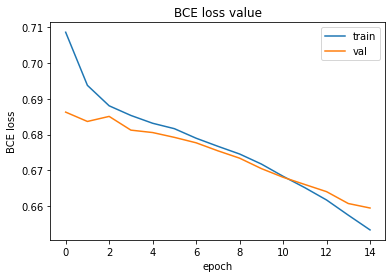

In [205]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

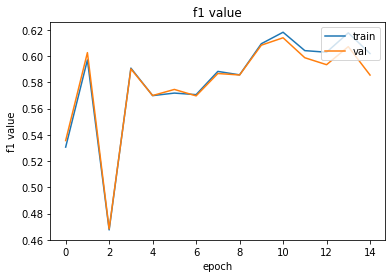

In [206]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [207]:
fp, fn, tp, tn = predict(model, val_iterator)

In [208]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.5852371656202184

In [209]:
fn[:5]

['ni вообще я залил всю клаву',
 'пришлось за минуту скидывать все шмотки',
 'же что без тебя серо и будь рядом',
 'от бизнес школ меня а на 1 пару',
 'вышел с к чтобы конфеты не забрали я всю химию ржу от этих конфет']

Подруженные эмбеддинги не улучшили результаты :(

Попробуем убрать предобработку текстов совсем. От переобучения я уже спасла модель тем, что добавила Dropout, уменьшила embedding_dim до 5, уменьшила in_features (и соответственно out_channels) до 140, разделила текст на train/val как 8 к 2. Learning rate 0.001 тоже помогает улучшить результаты + небольшое кол-во эпох предотвращает переобучение.

In [210]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(text.split(' '))
for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [211]:
class RawTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [212]:
train_dataset = RawTweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [213]:
val_dataset = RawTweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [214]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [215]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7565522577081408
Train loss: 0.727278602534327
Train loss: 0.7166480394926938
Train loss: 0.709829993167166
Train loss: 0.7047240822701841

Evaluating on train...
Val loss: 0.7280775734356472, Val f1: 0.5503952503204346
Val loss: 0.7032873877163591, Val f1: 0.5324893593788147
Val loss: 0.6945907338099047, Val f1: 0.5301176309585571
Val loss: 0.6905837897527016, Val f1: 0.5285765528678894
Val loss: 0.6881178134196514, Val f1: 0.5274788737297058

Evaluating on test...
Val loss: 0.9090291460355123, Val f1: 0.6811788082122803
Val loss: 0.7777931605066571, Val f1: 0.590686023235321
Val loss: 0.741567546671087, Val f1: 0.5665120482444763
Val loss: 0.7242537498474121, Val f1: 0.5549432635307312
Val loss: 0.7147782256728724, Val f1: 0.5500301718711853

starting Epoch 1
Training...
Train loss: 0.7314484289714268
Train loss: 0.7036728838394428
Train loss: 0.6937606998465278
Train loss: 0.6887872865644552
Train loss: 0.6849006849366266

Evaluating on tr

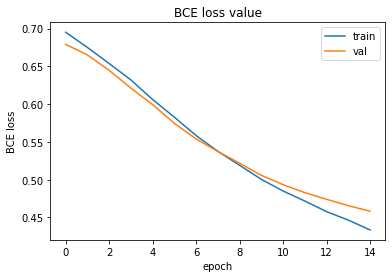

In [216]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

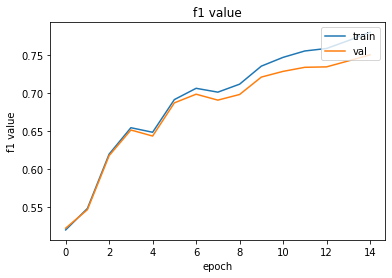

In [217]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [218]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7503236729409422

Результаты стали лучше, ура! По всей видимости, чем больше информации о тексте получает модель, тем лучше она справляется с задачей. Тем более при оценки тональности текстов в соц. сетях нужно учитывать смайлики/знаки препинания/скобки и тд, тк они важные индикаторы "настроения" автора. Посмотрим на ошибки модели.

In [219]:
fp[:5]

['RT RT Хочу смайлики как вк чтобы в твиттер и инстаграм писать с',
 '-Я самый худший                                                                                 - А у меня хлеб',
 'RT ты только',
 'RT на работе пить поставила положила печенье и порезала горячим',
 'кстати, никто еще с днем от не']

In [220]:
fn[:5]

['скучно наверно фильм смотреть хз',
 'Если какой я с тобой пойду. Хорошо иметь в жизни таких людей, которые способны сказать эти',
 'реквестирую возможность и при этом быть на него а то нихрена не спасает от а',
 'мы то с тобой обязательно',
 'я до "Не выдержала душа']

### Модель с комбинацией эмбеддингов и символьных признаков

In [224]:
vocab = Counter()
for text in tweets_data['prep_text']:
    vocab.update(text.split())

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

уникальных токенов, втретившихся больше 5 раз: 14917


In [225]:
char_vocab = Counter()
for text in tweets_data['prep_text']:
    for word in text:
      char_vocab.update(list(word))

filtered_char_vocab = set()

for word in char_vocab:
    if char_vocab[word] > 10:
        filtered_char_vocab.add(word)
print('уникальных токенов, втретившихся больше 10 раз:', len(filtered_char_vocab))

symbol2id = {'PAD':0}

for symbol in filtered_char_vocab:
    symbol2id[symbol] = len(symbol2id)

уникальных токенов, втретившихся больше 10 раз: 73


In [227]:
id2word = {i:word for word, i in word2id.items()}

In [228]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [231]:
ft_2 = FastText(tweets_data['prep_text'].tolist(), size=100, window=5, min_count=1)

In [232]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft_2.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [250]:
class WSTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['prep_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [251]:
train_dataset = WSTweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [252]:
val_dataset = WSTweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [253]:
class WSCNN(nn.Module):
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # word-level
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 

        # symbol-level
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)

        # both
        self.relu = nn.ReLU()   
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5) 
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded)))) 
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded)))) 
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vector = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq) 
        mean_emb_words = torch.mean(embedded_words, dim=1) 
        word_vector = self.dropout(self.word_hidden(mean_emb_words)) # тут был дропаут
        word_vector = self.dropout(self.relu(word_vector)) # тут был дропаут
        concat = torch.cat((symb_vector, word_vector), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [254]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (word_seq, symb_seq, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(word_seq, symb_seq)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):   
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке


In [255]:
model = WSCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [256]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7970502589430127
Train loss: 0.7439993249958959
Train loss: 0.7234059233557094
Train loss: 0.7108699275275409
Train loss: 0.7016369998455048

Evaluating on train...
Val loss: 0.711431486266, Val f1: 0.7110620141029358
Val loss: 0.6872936487197876, Val f1: 0.6851364374160767
Val loss: 0.6793504817919298, Val f1: 0.6788883805274963
Val loss: 0.6754608750343323, Val f1: 0.6748223900794983
Val loss: 0.6732387301084157, Val f1: 0.6728519797325134

Evaluating on test...
Val loss: 0.8837892214457194, Val f1: 0.8960347175598145
Val loss: 0.758181129183088, Val f1: 0.7598348259925842
Val loss: 0.7235158302567222, Val f1: 0.7296117544174194
Val loss: 0.7083022197087606, Val f1: 0.7111564874649048
Val loss: 0.6997516217984652, Val f1: 0.6997172832489014

starting Epoch 1
Training...
Train loss: 0.7021045429365975
Train loss: 0.6740649239770298
Train loss: 0.6632606807080182
Train loss: 0.6542869483010244
Train loss: 0.6474765716372309

Evaluating on tra

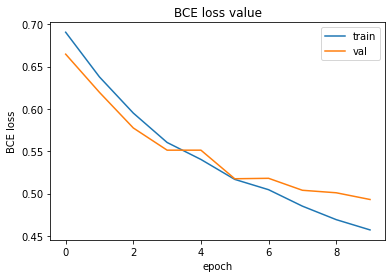

In [257]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

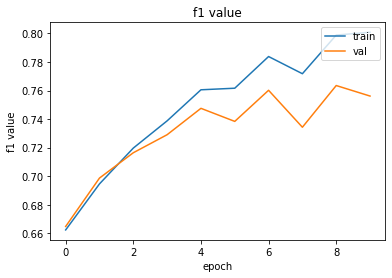

In [258]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [259]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):  
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, word_seq):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [260]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7563133185075365

In [261]:
tp[:5]

['USER давно не вам удачи вперед мои любимые ребята',
 'как дела что делаете как настроение а хотя вы такие пидары что не d',
 'нас уже 1 и так держать мы и дальше будем стараться для вас спасибо что вы с нами URL',
 'USER под тренд пусть лучше он под нас',
 'USER от бизнес школ меня освободили а на 1 пару ехать']

результат неплохой, попробуем убрать препроц + добавить эпох + не обрезать словарь по частотности

In [267]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(text.split())

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

char_vocab = Counter()
for text in tweets_data['text']:
    for word in text:
      char_vocab.update(list(word))

symbol2id = {'PAD':0}

for symbol in char_vocab:
    symbol2id[symbol] = len(symbol2id)

id2word = {i:word for word, i in word2id.items()}
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [270]:
print(len(symbol2id), len(word2id))

338 305485


In [271]:
class WSTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [272]:
train_dataset = WSTweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [273]:
val_dataset = WSTweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [274]:
model = WSCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [275]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7829427548817226
Train loss: 0.7261351840249424
Train loss: 0.6992298594929955
Train loss: 0.6746769416130195
Train loss: 0.6445169565645424

Evaluating on train...
Val loss: 0.4958380460739136, Val f1: 0.9539183378219604
Val loss: 0.47931364692490674, Val f1: 0.9194748997688293
Val loss: 0.4740449874238534, Val f1: 0.909337043762207
Val loss: 0.47069942446078283, Val f1: 0.9060183167457581
Val loss: 0.4695067498329523, Val f1: 0.9026559591293335

Evaluating on test...
Val loss: 0.6200776696205139, Val f1: 1.1890051364898682
Val loss: 0.5320288028035846, Val f1: 1.0152311325073242
Val loss: 0.5070147947831587, Val f1: 0.9716357588768005
Val loss: 0.4958838224411011, Val f1: 0.9492861032485962
Val loss: 0.4894339504994844, Val f1: 0.9364045858383179

starting Epoch 1
Training...
Train loss: 0.4115755132266453
Train loss: 0.3345758858425864
Train loss: 0.2807788750664754
Train loss: 0.24130230838969602
Train loss: 0.2117117068453415

Evaluating

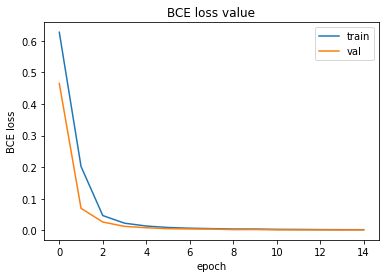

In [276]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

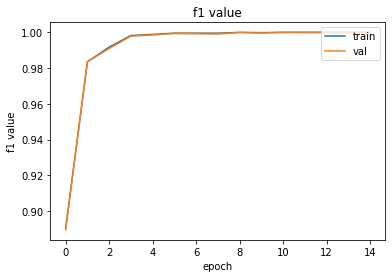

In [277]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [278]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.999755058051242

результат получился высоким. вывод: скобочки, смайлики и проч. сильно влияют на оценку тональности твитов. текст сам по себе не так важен, как символы, которыми он сопровождается. :)